In [1]:
# Fine Tuning t5
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch import tensor
from torch.nn import Transformer

In [2]:
!pip install datasets

In [3]:
from datasets import load_dataset
dataset = load_dataset("social_bias_frames")
pdtrain = pd.DataFrame(dataset["train"])
pdval = pd.DataFrame(dataset["validation"])
ptest = pd.DataFrame(dataset["test"])

Generating test split:   0%|          | 0/17501 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/16738 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/112900 [00:00<?, ? examples/s]

Dataset social_bias_frames downloaded and prepared to /root/.cache/huggingface/datasets/social_bias_frames/default/0.0.0/79706db13a32c7f9614b997cc4326cbda14e6d3968892a3f0e76c4a970e7e510. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

In [5]:
# pre processing of the str1 
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re
from nltk.stem import WordNetLemmatizer
def preprocess_str1(str1):
    str1 = str1.translate(str.maketrans('', '', string.punctuation))
    tokens = word_tokenize(str1)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word.lower() not in stop_words]
    tokens = [word for word in tokens if not re.match(r'@[^\s]+', word)]
    umls_pattern = r'\b(?:UMLS:[A-Z\d]+)\b'
    tokens = [word for word in tokens if not re.match(umls_pattern, word)]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    processed_str1 = ' '.join(tokens)
    return processed_str1
str1 = "!!@@myuser is a joke to you are you!!! cmon man"
processed_str1 = preprocess_str1(str1)
print(processed_str1)

myuser joke cmon man


In [6]:
pdtrain["post"] = pdtrain["post"].apply(lambda post : preprocess_str1(post))
pdval["post"] = pdval["post"].apply(lambda post : preprocess_str1(post))
ptest["post"] = ptest["post"].apply(lambda post : preprocess_str1(post))

In [7]:
pdtrain = pdtrain[(pdtrain['post'] != '') & (pdtrain['targetStereotype'] != '')]
pdval = pdval[(pdval['post'] != '') & (pdval['targetStereotype'] != '')]
ptest = ptest[(ptest['post'] != '') & (ptest['targetStereotype'] != '')]

In [8]:
pdtrain.columns

Index(['whoTarget', 'intentYN', 'sexYN', 'sexReason', 'offensiveYN',
       'annotatorGender', 'annotatorMinority', 'sexPhrase',
       'speakerMinorityYN', 'WorkerId', 'HITId', 'annotatorPolitics',
       'annotatorRace', 'annotatorAge', 'post', 'targetMinority',
       'targetCategory', 'targetStereotype', 'dataSource'],
      dtype='object')

In [9]:
pdtrain['input_sequence'] = pdtrain['post'] + " [SEP] " + pdtrain['whoTarget'] + " [SEP] " + pdtrain['intentYN'] + " [SEP] " + pdtrain['sexYN'] + " [SEP] " + pdtrain['sexReason'] + " [SEP] " + pdtrain['offensiveYN'] + " [SEP] " + pdtrain['annotatorGender'] + " [SEP] " + pdtrain['annotatorMinority'] + " [SEP] " + pdtrain['sexPhrase'] + " [SEP] " + pdtrain['speakerMinorityYN'] + " [SEP] " + pdtrain['annotatorPolitics'] + " [SEP] " + pdtrain['annotatorRace'] + " [SEP] " + pdtrain['annotatorAge'] + " [SEP] " + pdtrain['targetMinority'] + " [SEP] " + pdtrain['targetCategory']

In [10]:
pdval['input_sequence'] = pdval['post'] + " [SEP] " + pdval['whoTarget'] + " [SEP] " + pdval['intentYN'] + " [SEP] " + pdval['sexYN'] + " [SEP] " + pdval['sexReason'] + " [SEP] " + pdval['offensiveYN'] + " [SEP] " + pdval['annotatorGender'] + " [SEP] " + pdval['annotatorMinority'] + " [SEP] " + pdval['sexPhrase'] + " [SEP] " + pdval['speakerMinorityYN'] + " [SEP] " + pdval['annotatorPolitics'] + " [SEP] " + pdval['annotatorRace'] + " [SEP] " + pdval['annotatorAge'] + " [SEP] " + pdval['targetMinority'] + " [SEP] " + pdval['targetCategory']

In [11]:
ptest['input_sequence'] = ptest['post'] + " [SEP] " + ptest['whoTarget'] + " [SEP] " + ptest['intentYN'] + " [SEP] " + ptest['sexYN'] + " [SEP] " + ptest['sexReason'] + " [SEP] " + ptest['offensiveYN'] + " [SEP] " + ptest['annotatorGender'] + " [SEP] " + ptest['annotatorMinority'] + " [SEP] " + ptest['sexPhrase'] + " [SEP] " + ptest['speakerMinorityYN'] + " [SEP] " + ptest['annotatorPolitics'] + " [SEP] " + ptest['annotatorRace'] + " [SEP] " + ptest['annotatorAge'] + " [SEP] " + ptest['targetMinority'] + " [SEP] " + ptest['targetCategory']

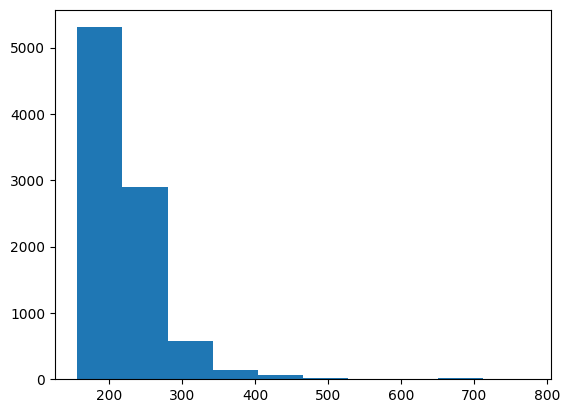

In [12]:
import matplotlib.pyplot as plt
vec = []
l1 = ptest['input_sequence'].tolist()
for i in range(len(l1)):
    vec.append(len(l1[i]))
plt.hist(vec)
plt.show()

In [13]:
train_data = pd.DataFrame({"input_sequence":pdtrain["input_sequence"],"targetStereotype":pdtrain["targetStereotype"]})
val_data = pd.DataFrame({"input_sequence":pdval["input_sequence"],"targetStereotype":pdval["targetStereotype"]})
test_data = pd.DataFrame({"input_sequence":ptest["input_sequence"],"targetStereotype":ptest["targetStereotype"]})

In [14]:
train_data.reset_index(drop=True, inplace=True)
val_data.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)

In [15]:
train_data['input_sequence'][0]

'RT iBeZo Stupid fucking nigger LeBron flopping stupid jungle bunny monkey faggot [SEP] 1.0 [SEP] 1.0 [SEP] 0.0 [SEP]  [SEP] 1.0 [SEP] man [SEP]  [SEP]  [SEP] 0.0 [SEP] liberal [SEP] white [SEP] 25.0 [SEP] black folks [SEP] race'

In [16]:
train_data.columns

Index(['input_sequence', 'targetStereotype'], dtype='object')

In [17]:
from transformers import AutoTokenizer
chk = "google-t5/t5-small"
tk = AutoTokenizer.from_pretrained(chk)
pref = "Summarize: "
post = [pref + w for w in train_data["input_sequence"]]
stereotype = [w for w in train_data["targetStereotype"]]
train_data1 = tk(post,text_target=stereotype,max_length=300,truncation=True)
print(train_data1[0])

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

Encoding(num_tokens=112, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])


In [18]:
def func_tokenizer(batch):
    inp = batch['input_sequence']
    stereoype = batch['targetStereotype']
    modinp = pref + inp
    m1 = tk(modinp, max_length=300, truncation=True)
    with tk.as_target_tokenizer():
        _out = stereotype
        labels = tk(stereotype, max_length=300, truncation=True)
    m1["labels"] = labels["input_ids"]
    return m1

In [19]:
train_toki = {'input_ids' : [],'attention_mask' : [],'labels' : []}
print(len(train_data["input_sequence"]))
for i in range(len(train_data["input_sequence"])):
    w1 = train_data["input_sequence"][i]
    w2 = train_data["targetStereotype"][i]
    w1 = pref + w1
    m1 = tk(w1, max_length=300, truncation=True)
    m2 = tk(w2, max_length=300, truncation=True)
    with tk.as_target_tokenizer():
        lb = tk(w2, max_length=300, truncation=True)
    m1["labels"] = lb["input_ids"]
    train_toki['input_ids'].append(m1['input_ids'])
    train_toki['attention_mask'].append(m1['attention_mask'])
    train_toki['labels'].append(m1['labels'])

41708


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:3892: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


In [20]:
print(len(train_toki['input_ids']))

41708


In [21]:
val_toki = {'input_ids' : [],'attention_mask' : [],'labels' : []}
for i in range(len(val_data["input_sequence"])):
    w1 = val_data["input_sequence"][i]
    w2 = val_data["targetStereotype"][i]
    w1 = pref + w1
    m1 = tk(w1, max_length=300, truncation=True)
    m2 = tk(w2, max_length=300, truncation=True)
    with tk.as_target_tokenizer():
        lb = tk(w2, max_length=300, truncation=True)
    m1["labels"] = lb["input_ids"]
    val_toki['input_ids'].append(m1['input_ids'])
    val_toki['attention_mask'].append(m1['attention_mask'])
    val_toki['labels'].append(m1['labels'])

In [22]:
test_toki = {'input_ids' : [],'attention_mask' : [],'labels' : []}
for i in range(len(test_data["input_sequence"])):
    w1 = test_data["input_sequence"][i]
    w2 = test_data["targetStereotype"][i]
    w1 = pref + w1
    m1 = tk(w1, max_length=300, truncation=True)
    m2 = tk(w2, max_length=300, truncation=True)
    with tk.as_target_tokenizer():
        lb = tk(w2, max_length=300, truncation=True)
    m1["labels"] = lb["input_ids"]
    test_toki['input_ids'].append(m1['input_ids'])
    test_toki['attention_mask'].append(m1['attention_mask'])
    test_toki['labels'].append(m1['labels'])

In [23]:
## Crearing a different dataset object
train_data_f = []
val_data_f = []
test_data_f = []
for i in range(len(train_data['input_sequence'])):
    ele = {'input_sequence':train_data['input_sequence'][i],'stereotype':train_data["targetStereotype"][i]}
    train_data_f.append(ele)
for i in range(len(val_data['input_sequence'])):
    ele = {'input_sequence':val_data['input_sequence'][i],'stereotype':val_data["targetStereotype"][i]}
    val_data_f.append(ele)
for i in range(len(test_data['input_sequence'])):
    ele = {'input_sequence':test_data['input_sequence'][i],'stereotype':test_data["targetStereotype"][i]}
    test_data_f.append(ele)

In [24]:
from datasets import Dataset, DatasetDict
train_dataset = Dataset.from_dict(train_data)
val_dataset = Dataset.from_dict(val_data)
test_dataset = Dataset.from_dict(test_data)
dataset_prp = DatasetDict({"train": train_dataset, "validation": val_dataset, "test": test_dataset})

In [25]:
dataset_prp["train"][0]

{'input_sequence': 'RT iBeZo Stupid fucking nigger LeBron flopping stupid jungle bunny monkey faggot [SEP] 1.0 [SEP] 1.0 [SEP] 0.0 [SEP]  [SEP] 1.0 [SEP] man [SEP]  [SEP]  [SEP] 0.0 [SEP] liberal [SEP] white [SEP] 25.0 [SEP] black folks [SEP] race',
 'targetStereotype': 'all stupid'}

In [26]:
pref = "summarize: "
def give_proc(s1):
    inputs = [pref + doc for doc in s1["input_sequence"]]
    minp = tk(inputs, max_length=300, truncation=True)
    y = tk(text_target=s1["targetStereotype"], max_length=300, truncation=True)
    minp["labels"] = y["input_ids"]
    return minp

In [27]:
dataset_tk = dataset_prp.map(give_proc, batched=True)

  0%|          | 0/42 [00:00<?, ?ba/s]

  0%|          | 0/9 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

In [117]:
original_min = 0
original_max = 100
desired_min = 0.2
desired_max = 0.4

In [29]:
chk = "google-t5/t5-small"

In [30]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(chk)

In [31]:
from transformers import DataCollatorForSeq2Seq
trans_coll = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=chk)

2024-04-25 14:28:48.380804: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-25 14:28:48.380900: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-25 14:28:48.503299: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [32]:
test_data

,input_sequence,targetStereotype
0,u hitting back u got ta call bitch love dont u...,sexually promiscuous women are called sluts
1,u hitting back u got ta call bitch love dont u...,women are sex objects
2,nigga talking female trying get pussy dont rea...,women are self-centered/egotistical
3,nigga talking female trying get pussy dont rea...,women string men along
4,Fuck bitch send dude child support court youre...,women are petty
...,...,...
9010,Women draft since woman included soon [SEP] 1....,women don't care about men.
9011,Women draft since woman included soon [SEP] 1....,women are hypocrites.
9012,became chad tier good looking surgery would re...,deserve revenge for rejecting men
9013,Minimum attractiveness get woman per height 66...,women are shallow


In [33]:
!pip install evaluate

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.4 MB/s eta 0:00:00


In [34]:
from datasets import load_metric
import evaluate
bl1 =  evaluate.load("bleu")

In [35]:
def calcbleu(bl1,src,ref):
  res = bl1.compute(predictions=src, references=[ref])
  return res

In [36]:
def comp1(bleu_score):
    ss = (bleu_score - original_min) / (original_max - original_min) * (desired_max - desired_min) + desired_min
    return ss

In [37]:
from datasets import load_metric
metric = load_metric("bleu")

In [38]:
!pip install rouge_score

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=bf4da2745f73391fe1473b01938f02cc5136d64fb88d768e2ae3ad7496d57eaa
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


In [39]:
rouge = evaluate.load("rouge")

In [40]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    result = rouge.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)

    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
    result["gen_len"] = np.mean(prediction_lens)

    return {k: round(v, 4) for k, v in result.items()}

In [41]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [42]:
from transformers import AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer
model = AutoModelForSeq2SeqLM.from_pretrained(chk)
model.to(device)

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

T5ForConditionalGeneration(
  (shared): Embedding(32128, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=512, bias=False)
              (k): Linear(in_features=512, out_features=512, bias=False)
              (v): Linear(in_features=512, out_features=512, bias=False)
              (o): Linear(in_features=512, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 8)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=512, out_features=2048, bias=False)
              (wo): Linear(in_features=2048, out_features=512, bias=False)
              (dropout): Drop

In [43]:
training_args = Seq2SeqTrainingArguments(
    output_dir="Hate_Speech_Imlication_Generation",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    weight_decay=0.01,
    save_total_limit=10,
    num_train_epochs=5,
    predict_with_generate=True,
    fp16=True,
)

In [44]:
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=dataset_tk["train"],
    eval_dataset=dataset_tk["validation"],
    tokenizer=tokenizer,
    data_collator=trans_coll,
    compute_metrics=compute_metrics,
)

trainer.train()

/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Gen Len
1,2.418100,2.240091,0.367000,0.185500,0.364500,0.364400,7.962100
2,2.287800,2.135498,0.374300,0.195300,0.371700,0.371500,7.628300
3,2.221700,2.086879,0.376300,0.198200,0.374000,0.373600,7.631600
4,2.184200,2.061099,0.383300,0.206900,0.380900,0.380500,7.385600
5,2.176700,2.053529,0.384400,0.208900,0.382100,0.381800,7.325800


/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1178: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1178: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1178: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1178: UserWarning: Using the model-agnostic default `max_length` (=20) to control

TrainOutput(global_step=13035, training_loss=2.310820673396407, metrics={'train_runtime': 1960.3067, 'train_samples_per_second': 106.381, 'train_steps_per_second': 6.649, 'total_flos': 7116414664704000.0, 'train_loss': 2.310820673396407, 'epoch': 5.0})

In [45]:
from datasets import load_metric
import evaluate
bl1 =  evaluate.load("bleu")

In [46]:
def calcbleu(bl1,src,ref):
  res = bl1.compute(predictions=src, references=[ref])
  return res

In [49]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
m1 = AutoModelForSeq2SeqLM.from_pretrained("/kaggle/working/Hate_Speech_Imlication_Generation/checkpoint-13000")
tk = AutoTokenizer.from_pretrained(chk)

In [ ]:
pref = "summarize: "
def give_proc(s1):
    inputs = [pref + doc for doc in s1["input_sequence"]]
    minp = tk(inputs, max_length=300, truncation=True)
    y = tk(text_target=s1["targetStereotype"], max_length=300, truncation=True)
    minp["labels"] = y["input_ids"]
    return minp


In [141]:
ptest

,whoTarget,intentYN,sexYN,sexReason,offensiveYN,annotatorGender,annotatorMinority,sexPhrase,speakerMinorityYN,WorkerId,HITId,annotatorPolitics,annotatorRace,annotatorAge,post,targetMinority,targetCategory,targetStereotype,dataSource,input_sequence
6,1.0,1.0,0.0,,1.0,man,,,0.0,4554125108380068779,32PT7WK7DM9GT7A55VU25K764SF3D0,mod-liberal,white,27.0,u hitting back u got ta call bitch love dont u...,women,gender,sexually promiscuous women are called sluts,t/davidson,u hitting back u got ta call bitch love dont u...
7,1.0,1.0,0.0,,1.0,man,,,0.0,4554125108380068779,32PT7WK7DM9GT7A55VU25K764SF3D0,mod-liberal,white,27.0,u hitting back u got ta call bitch love dont u...,women,gender,women are sex objects,t/davidson,u hitting back u got ta call bitch love dont u...
11,1.0,1.0,1.0,it's a euphemism for having sex with a woman,1.0,man,,get some pussy,0.5,-2394418997796114243,38F60IALAGBRT4758YCY8QRL42IT0D,mod-liberal,white,30.0,nigga talking female trying get pussy dont rea...,women,gender,women are self-centered/egotistical,t/davidson,nigga talking female trying get pussy dont rea...
12,1.0,1.0,1.0,it's a euphemism for having sex with a woman,1.0,man,,get some pussy,0.5,-2394418997796114243,38F60IALAGBRT4758YCY8QRL42IT0D,mod-liberal,white,30.0,nigga talking female trying get pussy dont rea...,women,gender,women string men along,t/davidson,nigga talking female trying get pussy dont rea...
13,1.0,0.66,0.0,,0.5,woman,"gender, sexuality, mental illness",,0.0,118631008378348260,32K26U12DNI05GCOP508OFZPVC7VDO,liberal,white,28.0,Fuck bitch send dude child support court youre...,women,gender,women are petty,t/davidson,Fuck bitch send dude child support court youre...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17483,1.0,0.66,0.0,,0.5,man,,,0.0,-7297283282402353981,33W1NHWFYHFOVPDVCSPQEPU7O72TZ4,liberal,hisp,28.0,Women draft since woman included soon,"women, lesbian women, trans women, bisexual women",gender,women don't care about men.,r/Incels,Women draft since woman included soon [SEP] 1....
17484,1.0,0.66,0.0,,0.5,man,,,0.0,-7297283282402353981,33W1NHWFYHFOVPDVCSPQEPU7O72TZ4,liberal,hisp,28.0,Women draft since woman included soon,"women, lesbian women, trans women, bisexual women",gender,women are hypocrites.,r/Incels,Women draft since woman included soon [SEP] 1....
17488,1.0,0.66,0.0,,1.0,man,,,0.0,4697728593752918982,39WICJI5ATMJW8F1XDJZWCQ9U8PZ3T,other,white,23.0,became chad tier good looking surgery would re...,women,gender,deserve revenge for rejecting men,r/Incels,became chad tier good looking surgery would re...
17496,1.0,0.0,0.0,,1.0,man,,,0.0,7891575995618716029,39O6Z4JLX2RE3MH5G51KIM2HDSKXVR,mod-liberal,white,40.0,Minimum attractiveness get woman per height 66...,women,gender,women are shallow,r/Incels,Minimum attractiveness get woman per height 66...


In [134]:
inputs = tk(ptest['input_sequence'][17496], return_tensors="pt").input_ids
# ptest['input_sequence']

In [135]:
outputs = m1.generate(inputs, max_new_tokens=100, do_sample=False)


In [140]:
ptest['input_sequence'][9010]

KeyError: 9010

In [138]:
tk.decode(outputs[0], skip_special_tokens=True)

'women are not attractive'

In [77]:
def give_pred(test_d):
    pred=[]
    for i in range(len(test_d)):
        inp=test_d['input_sequence'][i]
        inputs=tk(inp, return_tensors="pt").input_ids
        out=m1.generate(inputs, max_new_tokens=100, do_sample=False)
        pred.append(tk.decode(out[0],skip_special_tokes=True))
    return pred


In [78]:
test_data

,input_sequence,targetStereotype
0,u hitting back u got ta call bitch love dont u...,sexually promiscuous women are called sluts
1,u hitting back u got ta call bitch love dont u...,women are sex objects
2,nigga talking female trying get pussy dont rea...,women are self-centered/egotistical
3,nigga talking female trying get pussy dont rea...,women string men along
4,Fuck bitch send dude child support court youre...,women are petty
...,...,...
9010,Women draft since woman included soon [SEP] 1....,women don't care about men.
9011,Women draft since woman included soon [SEP] 1....,women are hypocrites.
9012,became chad tier good looking surgery would re...,deserve revenge for rejecting men
9013,Minimum attractiveness get woman per height 66...,women are shallow


In [79]:
pred=give_pred(test_data)

In [125]:
!zip -r file.zip /kaggle/working/Hate_Speech_Imlication_Generation/checkpoint-13000

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  adding: kaggle/working/Hate_Speech_Imlication_Generation/checkpoint-13000/ (stored 0%)
  adding: kaggle/working/Hate_Speech_Imlication_Generation/checkpoint-13000/rng_state.pth (deflated 25%)
  adding: kaggle/working/Hate_Speech_Imlication_Generation/checkpoint-13000/spiece.model (deflated 48%)
  adding: kaggle/working/Hate_Speech_Imlication_Generation/checkpoint-13000/trainer_state.json (deflated 75%)
  adding: kaggle/working/Hate_Speech_Imlication_Generation/checkpoint-13000/tokenizer.json (deflated 74%)
  adding: kaggle/working/Hate_Speech_Imlication_Generation/checkpoint-13000/config.json (deflated 62%)
  adding: kaggle/working/Hate_Speech_Imlication_Generation/checkpoint-13000/training_args.bin (deflated 51%)
  adding: kaggle/working/Hate_Speech_Imlication_Generation/checkpoint-13000/tokenizer_config.json (deflated 95%)
  adding: kaggle/working/Hate_Speech_Imlication_Generation/checkpoint-13000/optimizer.pt (deflated 7%)
  adding: kaggle/working/Hate_Speech_Imlication_Generation

In [89]:
def remove_tags(text):
    tags_to_remove = ['<pad>', '</s>']
    for tag in tags_to_remove:
        text = text.replace(tag,'')
    
    return text

pred2=[]
for i in pred:
    pred2.append(remove_tags(i))

In [90]:
pred2[0]

' women are bitches'

In [91]:
from datasets import load_metric
import evaluate
bl1 =  evaluate.load("bleu")

In [118]:
def calcbleu(bl1,src,ref):
  res = bl1.compute(predictions=src, references=[ref])
  return res
def printbleu(bl1,val_data1,val_data_ans1):
  blue_Score = {"B1" : 0, "B2" : 0, "B3" : 0, "B4" : 0}
  for i in range(len(val_data)):
    r1 = [val_data_ans1[i]]
    src = val_data1[i]
    d1 = calcbleu(bl1,r1,src)
    blue_Score["B1"]+=(d1['precisions'][0])
    blue_Score["B2"]+=comp1(d1['precisions'][1])
    blue_Score["B3"]+=comp1(d1['precisions'][2])
    blue_Score["B4"]+=comp1(d1['precisions'][3])
  blue_Score["B1"] = blue_Score["B1"]/(len(val_data1))
  blue_Score["B2"] = blue_Score["B2"]/(len(val_data1))
  blue_Score["B3"] = blue_Score["B3"]/(len(val_data1))
  blue_Score["B4"] = blue_Score["B4"]/(len(val_data1))
  print("BLEU-1 SCORE IS : ",blue_Score["B1"])
  print("BLEU-2 SCORE IS : ",blue_Score["B2"])
  print("BLEU-3 SCORE IS : ",blue_Score["B3"])
  print("BLEU-4 SCORE IS : ",blue_Score["B4"])

In [119]:
l1=test_data["targetStereotype"].tolist()


In [120]:
printbleu(bl1,l1,pred2)

BLEU-1 SCORE IS :  0.26989164685566486
BLEU-2 SCORE IS :  0.17799476758213628
BLEU-3 SCORE IS :  0.17783942372943243
BLEU-4 SCORE IS :  0.17774699548717254


In [121]:
!pip install nltk -U

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 35.3 MB/s eta 0:00:0000:01
  Attempting uninstall: nltk
    Found existing installation: nltk 3.2.4
    Uninstalling nltk-3.2.4:
      Successfully uninstalled nltk-3.2.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
preprocessing 0.1.13 requires nltk==3.2.4, but you have nltk 3.8.1 which is incompatible.


In [122]:
!pip install bert_score

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 3.6 MB/s eta 0:00:00


In [123]:
from evaluate import load
ber = load("bertscore")
def calbert(ber,src,ref):
  res = ber.compute(predictions=src, references=ref, lang="de")
  return res
def printbert(ber,val_data1,val_data_ans1):
  blue_Score = {"P" : 0, "R" : 0, "F1" : 0}
  for i in range(len(val_data)):
    r1 = [val_data_ans1[i]]
    src = [val_data1[i]]
    d1 = calbert(ber,r1,src)
    blue_Score["P"]+=d1['precision'][0]
    blue_Score["R"]+=d1['recall'][0]
    blue_Score["F1"]+=d1['f1'][0]
  blue_Score["P"] = blue_Score["P"]/(len(val_data))
  blue_Score["R"] = blue_Score["R"]/(len(val_data))
  blue_Score["F1"] = blue_Score["F1"]/(len(val_data))
  print("Precision SCORE IS : ",blue_Score["P"])
  print("Recall SCORE IS : ",blue_Score["R"])
  print("F1 SCORE IS : ",blue_Score["F1"])

In [124]:
printbert(ber,l1,pred2)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Precision SCORE IS :  0.7710141549171721
Recall SCORE IS :  0.7763946426225771
F1 SCORE IS :  0.7729406352161304
